In [91]:
import pandas as pd
import time
import torch
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import SAGEConv
from torchmetrics import Accuracy
from torch_geometric.data import Data
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [93]:
# ---------------------------------------------------
# 1. Load CSVs
# ---------------------------------------------------
# Change path to the correct file path on your computer
path = "C:/Users/viczh/elliptic-data-set/elliptic_bitcoin_dataset/"

features_df = pd.read_csv(path + "elliptic_txs_features.csv", header=None)
classes_df  = pd.read_csv(path + "elliptic_txs_classes.csv")
edges_df    = pd.read_csv(path + "elliptic_txs_edgelist.csv")

colnames = ["txId", "timestep"] + [f"f_{i}" for i in range(165)]
features_df.columns = colnames

features_df = features_df.merge(classes_df, on="txId", how="left")

features_df = features_df[features_df["class"] != "unknown"]   # keep only labeled data

features_df = features_df.drop(columns=["class"])

classes_df = classes_df[classes_df["class"] != "unknown"]

classes_df["class"] = classes_df["class"].map({'1': 1, '2': 0})

classes_df.head()

,txId,class
3,232438397,0
9,232029206,0
10,232344069,0
11,27553029,0
16,3881097,0


In [95]:
# ---------------------------------------------------
# 2. Prepare node features
# ---------------------------------------------------
# column 0 = txId, column 1 = timestep, columns 2-167 = 166 features
tx_id = features_df.iloc[:, 0].values
timestep = features_df.iloc[:, 1].values
X = features_df.iloc[:, 2:].values             # shape (203k, 166)

# Map txID → contiguous index 0..N-1
txid_to_idx = {tid: i for i, tid in enumerate(tx_id)}

# Convert to torch
x = torch.tensor(X, dtype=torch.float)
timestep = torch.tensor(timestep, dtype=torch.long)

# ---------------------------------------------------
# 3. Prepare labels
# ---------------------------------------------------
# classes.csv has columns: txId, class
y_map = {row.txId: row['class'] for _, row in classes_df.iterrows()}

# Convert labels to aligned vector
#y = torch.full((len(tx_id),), -1, dtype=torch.long)   # unknown = -1
#for tid, label in y_map.items():
#    y[txid_to_idx[tid]] = int(label) - 1  # convert class1/2 → 0/1

# ---------------------------------------------------
# 4. Prepare edges (directed)
# ---------------------------------------------------
src = []
dst = []

for _, row in edges_df.iterrows():
    t1 = row.txId1
    t2 = row.txId2

    if t1 in txid_to_idx and t2 in txid_to_idx:  # keep only valid edges
        src.append(txid_to_idx[t1])
        dst.append(txid_to_idx[t2])

edge_index = torch.tensor([src, dst], dtype=torch.long)

# ---------------------------------------------------
# 5. Create PyG Data object
# ---------------------------------------------------
data = Data(
    x=x,
    y=y,
    edge_index=edge_index,
    timestep=timestep
)

print(data)

Data(x=[46564, 165], edge_index=[2, 36624], y=[46564], timestep=[46564])


In [49]:
data.train_mask = (data.timestep < 35) 
data.val_mask   = (data.timestep >= 35) & (data.timestep < 42) 
data.test_mask  = (data.timestep >= 42) 

In [59]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.classifier = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        return self.classifier(x)

model = GraphSAGE(
    in_channels=data.x.size(1),
    hidden_channels=64,
    out_channels=2
)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

acc = Accuracy(task="multiclass", num_classes=2)

train_mask = data.train_mask
val_mask   = data.val_mask
test_mask  = data.test_mask

In [61]:
for epoch in range(1, 51):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()

    model.eval()
    val_out = model(data.x, data.edge_index)
    val_acc = acc(val_out[val_mask], data.y[val_mask])

    print(f"Epoch {epoch:02d} | Loss: {loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch 01 | Loss: 0.5543 | Val Acc: 0.9137
Epoch 02 | Loss: 0.4987 | Val Acc: 0.9138
Epoch 03 | Loss: 0.4545 | Val Acc: 0.9138
Epoch 04 | Loss: 0.4180 | Val Acc: 0.9138
Epoch 05 | Loss: 0.3876 | Val Acc: 0.9138
Epoch 06 | Loss: 0.3620 | Val Acc: 0.9138
Epoch 07 | Loss: 0.3404 | Val Acc: 0.9138
Epoch 08 | Loss: 0.3221 | Val Acc: 0.9138
Epoch 09 | Loss: 0.3064 | Val Acc: 0.9138
Epoch 10 | Loss: 0.2931 | Val Acc: 0.9138
Epoch 11 | Loss: 0.2817 | Val Acc: 0.9138
Epoch 12 | Loss: 0.2720 | Val Acc: 0.9138
Epoch 13 | Loss: 0.2637 | Val Acc: 0.9138
Epoch 14 | Loss: 0.2566 | Val Acc: 0.9138
Epoch 15 | Loss: 0.2504 | Val Acc: 0.9138
Epoch 16 | Loss: 0.2451 | Val Acc: 0.9138
Epoch 17 | Loss: 0.2404 | Val Acc: 0.9138
Epoch 18 | Loss: 0.2362 | Val Acc: 0.9138
Epoch 19 | Loss: 0.2324 | Val Acc: 0.9138
Epoch 20 | Loss: 0.2289 | Val Acc: 0.9138
Epoch 21 | Loss: 0.2256 | Val Acc: 0.9138
Epoch 22 | Loss: 0.2225 | Val Acc: 0.9138
Epoch 23 | Loss: 0.2195 | Val Acc: 0.9138
Epoch 24 | Loss: 0.2166 | Val Acc:

In [71]:
# ---------------------------------------
# 1. Get predictions on the test set
# ---------------------------------------
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)

# Predictions
test_logits = out[data.test_mask]
test_labels = data.y[data.test_mask]

preds = test_logits.argmax(dim=1).cpu().numpy()
true  = test_labels.cpu().numpy()

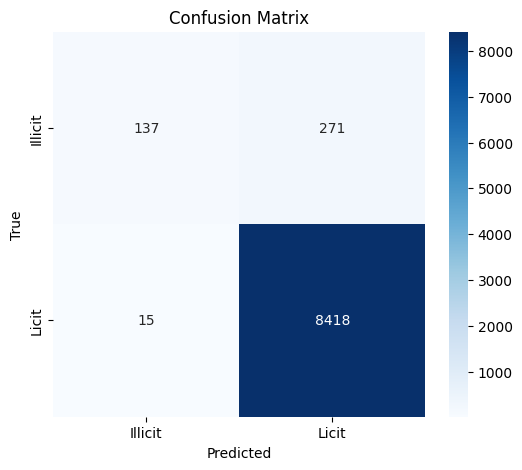

In [79]:
cm = confusion_matrix(true, preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Illicit", "Licit"],
            yticklabels=["Illicit", "Licit"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [81]:
report = classification_report(true, preds, target_names=["Illicit", "Licit"])
print(report)

              precision    recall  f1-score   support

     Illicit       0.90      0.34      0.49       408
       Licit       0.97      1.00      0.98      8433

    accuracy                           0.97      8841
   macro avg       0.94      0.67      0.74      8841
weighted avg       0.97      0.97      0.96      8841

